# Create a dataset for FHI 2020 Pads (with lactose, blank and Swiped but un-run PADs)

1. load data
2. Add other PADs type:
   1. - Lactose PAD
   2. - Swiped but un-run PAD
   3. - Blank PAD

3. General Analysis of the clean data
4. Split data into dev and test
5. Save metadata
6. Persist the data with DVC


# Import libs

In [3]:
import sys
#import ipyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../src/")
from utils import *



# Parameters

In [40]:
#  
DATASET_NAME = 'DATASET__FHI_2020_strat_sampling'
STORAGE_DIR = f"../../../data/intermediate/{DATASET_NAME}/"

# projects to be used com compose final dataset
PROJECT_ID = [11, 12]

# pattern to read data from each project
DATA_FNAME = f"{STORAGE_DIR}/data_project-id-X.csv"

# dir for saving the final dataset
DATASET_ROOT_DIR = '../../../datasets/FHI2020_Stratified_Sampling/'

# report data dir
REPORT_DIR = f"{DATASET_ROOT_DIR}/report"



# 1. Load data

In [5]:
# load data
proj_1_df = pd.read_csv(DATA_FNAME.replace('X', str(PROJECT_ID[0])))
proj_2_df = pd.read_csv(DATA_FNAME.replace('X', str(PROJECT_ID[1])))

# 2. Combine projects

- **2.1. `For proj_1_df`:** Use all drug classes and Lactose but remove others distractors.
- **2.2. `For proj_2_df`:** Use swiped but un-run and blank PADs from this project.
- **2.3. Combine `proj_1 and proj_2`**
  
*Note : For the lactose "detection" what we are really picking up is "there is no detectable drug on this PAD, although some substance got swiped and the PAD was run"*

## 2.1. `For proj_1_df`: Keep Lactose and remove others distractors

In [6]:
remove_distractors = ['calcium-carbonate', 'starch-(maize)', 'ascorbic-acid']

print(f"Total of images before {len(proj_1_df)}")

proj_1_df = proj_1_df.loc[~proj_1_df.sample_name.isin(remove_distractors)]
proj_1_df.reset_index(drop=True, inplace=True)

print(f"Total of images after {len(proj_1_df)}")

Total of images before 7888
Total of images after 7715


## 2.2. `For proj_2_df`: Use swiped but un-run and Blank PADs

In [7]:
proj_2_df.sample_name.unique()

array(['swiped-but-not-run', 'blank'], dtype=object)

##  2.3. Combine `proj_1 and proj_2`

In [8]:
data = pd.concat([proj_1_df, proj_2_df], axis=0)
data

,id,sample_id,sample_name,quantity,camera_type_1,project.id,url,hashlib_md5
0,15214,53698,amoxicillin,100,Google Pixel 3a,11,https://pad.crc.nd.edu//var/www/html/images/pa...,5a2e10df1774f1941e0b5268da64ee6a
1,15215,53691,amoxicillin,100,Google Pixel 3a,11,https://pad.crc.nd.edu//var/www/html/images/pa...,3ccc5f7a45a7eb0d0d4cd6ae84e409b0
2,15216,53698,amoxicillin,100,Google Pixel 3a,11,https://pad.crc.nd.edu//var/www/html/images/pa...,654d7fd30b4a33db3c0f99cb5494de3c
3,15218,53691,amoxicillin,100,Google Pixel 3a,11,https://pad.crc.nd.edu//var/www/html/images/pa...,d66df94b627ec91f53960fa1d27f8ee3
4,15221,53694,amoxicillin,100,Google Pixel 3a,11,https://pad.crc.nd.edu//var/www/html/images/pa...,935d35bcc61257d40dcac5724c212954
...,...,...,...,...,...,...,...,...
281,46173,66335,blank,0,Google Pixel 3a,12,https://pad.crc.nd.edu//var/www/html/images/pa...,76cd5adc83f3893be6f5d67a19bd324a
282,46174,66332,blank,0,Google Pixel 3a,12,https://pad.crc.nd.edu//var/www/html/images/pa...,91c9233e4a18a8970c247125efd85776
283,46175,66334,blank,0,Google Pixel 3a,12,https://pad.crc.nd.edu//var/www/html/images/pa...,060e8a91f123f8a599c9a020a07ffb83
284,46176,66333,blank,0,Google Pixel 3a,12,https://pad.crc.nd.edu//var/www/html/images/pa...,02ed26b7f059f341848b333457436621


## 2.4 Add the column `is_drug`

Add the column `is_drug` to data so we can distinguish between PADs with drugs or other type. 

In [9]:
data['is_drug'] = True
data.loc[data.sample_name.isin(['lactose','swiped-but-not-run','blank']),'is_drug'] = False

# 3.General Analysis of the clean data

- 3.1. Analyze by Images
   - 1. List Sample Names and their corresponding number of images
   - 2. Check the distribution of the number of images by drug and quantity
   - 3. Check images by camera type
      - 1. Check the distribution of the number of images by camera 
      - 2. Check the distribution of the number of images by camera and drug
- 3.2. Analyze by Card
   - 1. List Sample Names and their corresponding number of cards
   - 2. Check the distribution of the number of cards by drug and quantity

## 3.1. Analyze by Images

- 3.1.1. List Sample Names

There are two types of sample name: *`Drugs`* and *`no Drugs`*.

In [10]:
print(f"Drugs:\t{len(data[data.is_drug].sample_name.unique())}")
print(f"Others:\t{len(data[~data.is_drug].sample_name.unique())}")

Drugs:	20
Others:	3


In [11]:
img_counter_by_drug = data[data.is_drug].value_counts(['sample_name']).reset_index(name='counts')
img_counter_by_drug

,sample_name,counts
0,hydroxychloroquine,821
1,rifampicin,476
2,ciprofloxacin,455
3,pyrazinamide,447
4,ferrous-sulfate,438
5,chloroquine,438
6,azithromycin,438
7,ripe,427
8,ethambutol,403
9,ceftriaxone,387


In [12]:
img_counter_by_nodrug = data[~data.is_drug].value_counts(['sample_name']).reset_index(name='counts')
img_counter_by_nodrug

,sample_name,counts
0,blank,208
1,swiped-but-not-run,78
2,lactose,71


- sort the list of sample_name by drugs and then no-drugs.

In [13]:
# list of drugs name sorted by the number of images
drugs = img_counter_by_drug.sample_name.to_list()
no_drugs = img_counter_by_drug.sample_name.to_list()
name_list = drugs + ['lactose', 'blank','swiped-but-not-run']

### Check the distribution of the number of images by sample_name and quantity

In [16]:
# # plot the distribution of the number of images per drug
img_counter_by_drug_quantity = data[['sample_name', 'quantity']].value_counts().reset_index(name='counts')
img_counter_by_drug_quantity.sort_values(by=['sample_name', 'quantity'], inplace=True)


### Check the distribution of the number of images for a specific drug

In [17]:
drug = 'benzyl-penicillin'
img_counter_by_drug_quantity[img_counter_by_drug_quantity['sample_name']==drug]

,sample_name,quantity,counts
80,benzyl-penicillin,20,29
82,benzyl-penicillin,50,12
79,benzyl-penicillin,80,31
81,benzyl-penicillin,100,22


<Axes: xlabel='quantity', ylabel='sample_name'>

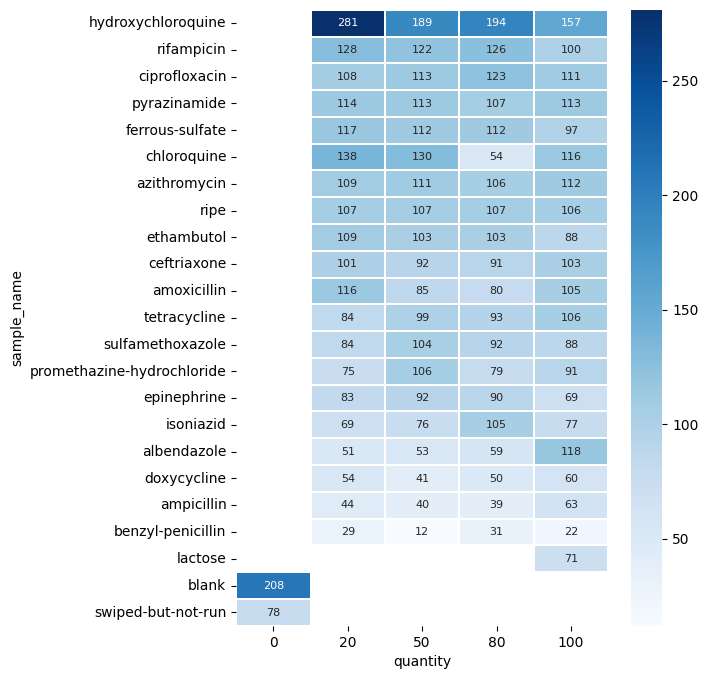

In [18]:
img_counter_by_drug_quantity = img_counter_by_drug_quantity.copy()
img_counter_by_drug_quantity['sample_name'] = pd.Categorical(img_counter_by_drug_quantity['sample_name'], name_list)

table = img_counter_by_drug_quantity.pivot(index="sample_name", columns="quantity", values="counts")
fig, ax = plt.subplots(figsize=(6, 8))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)

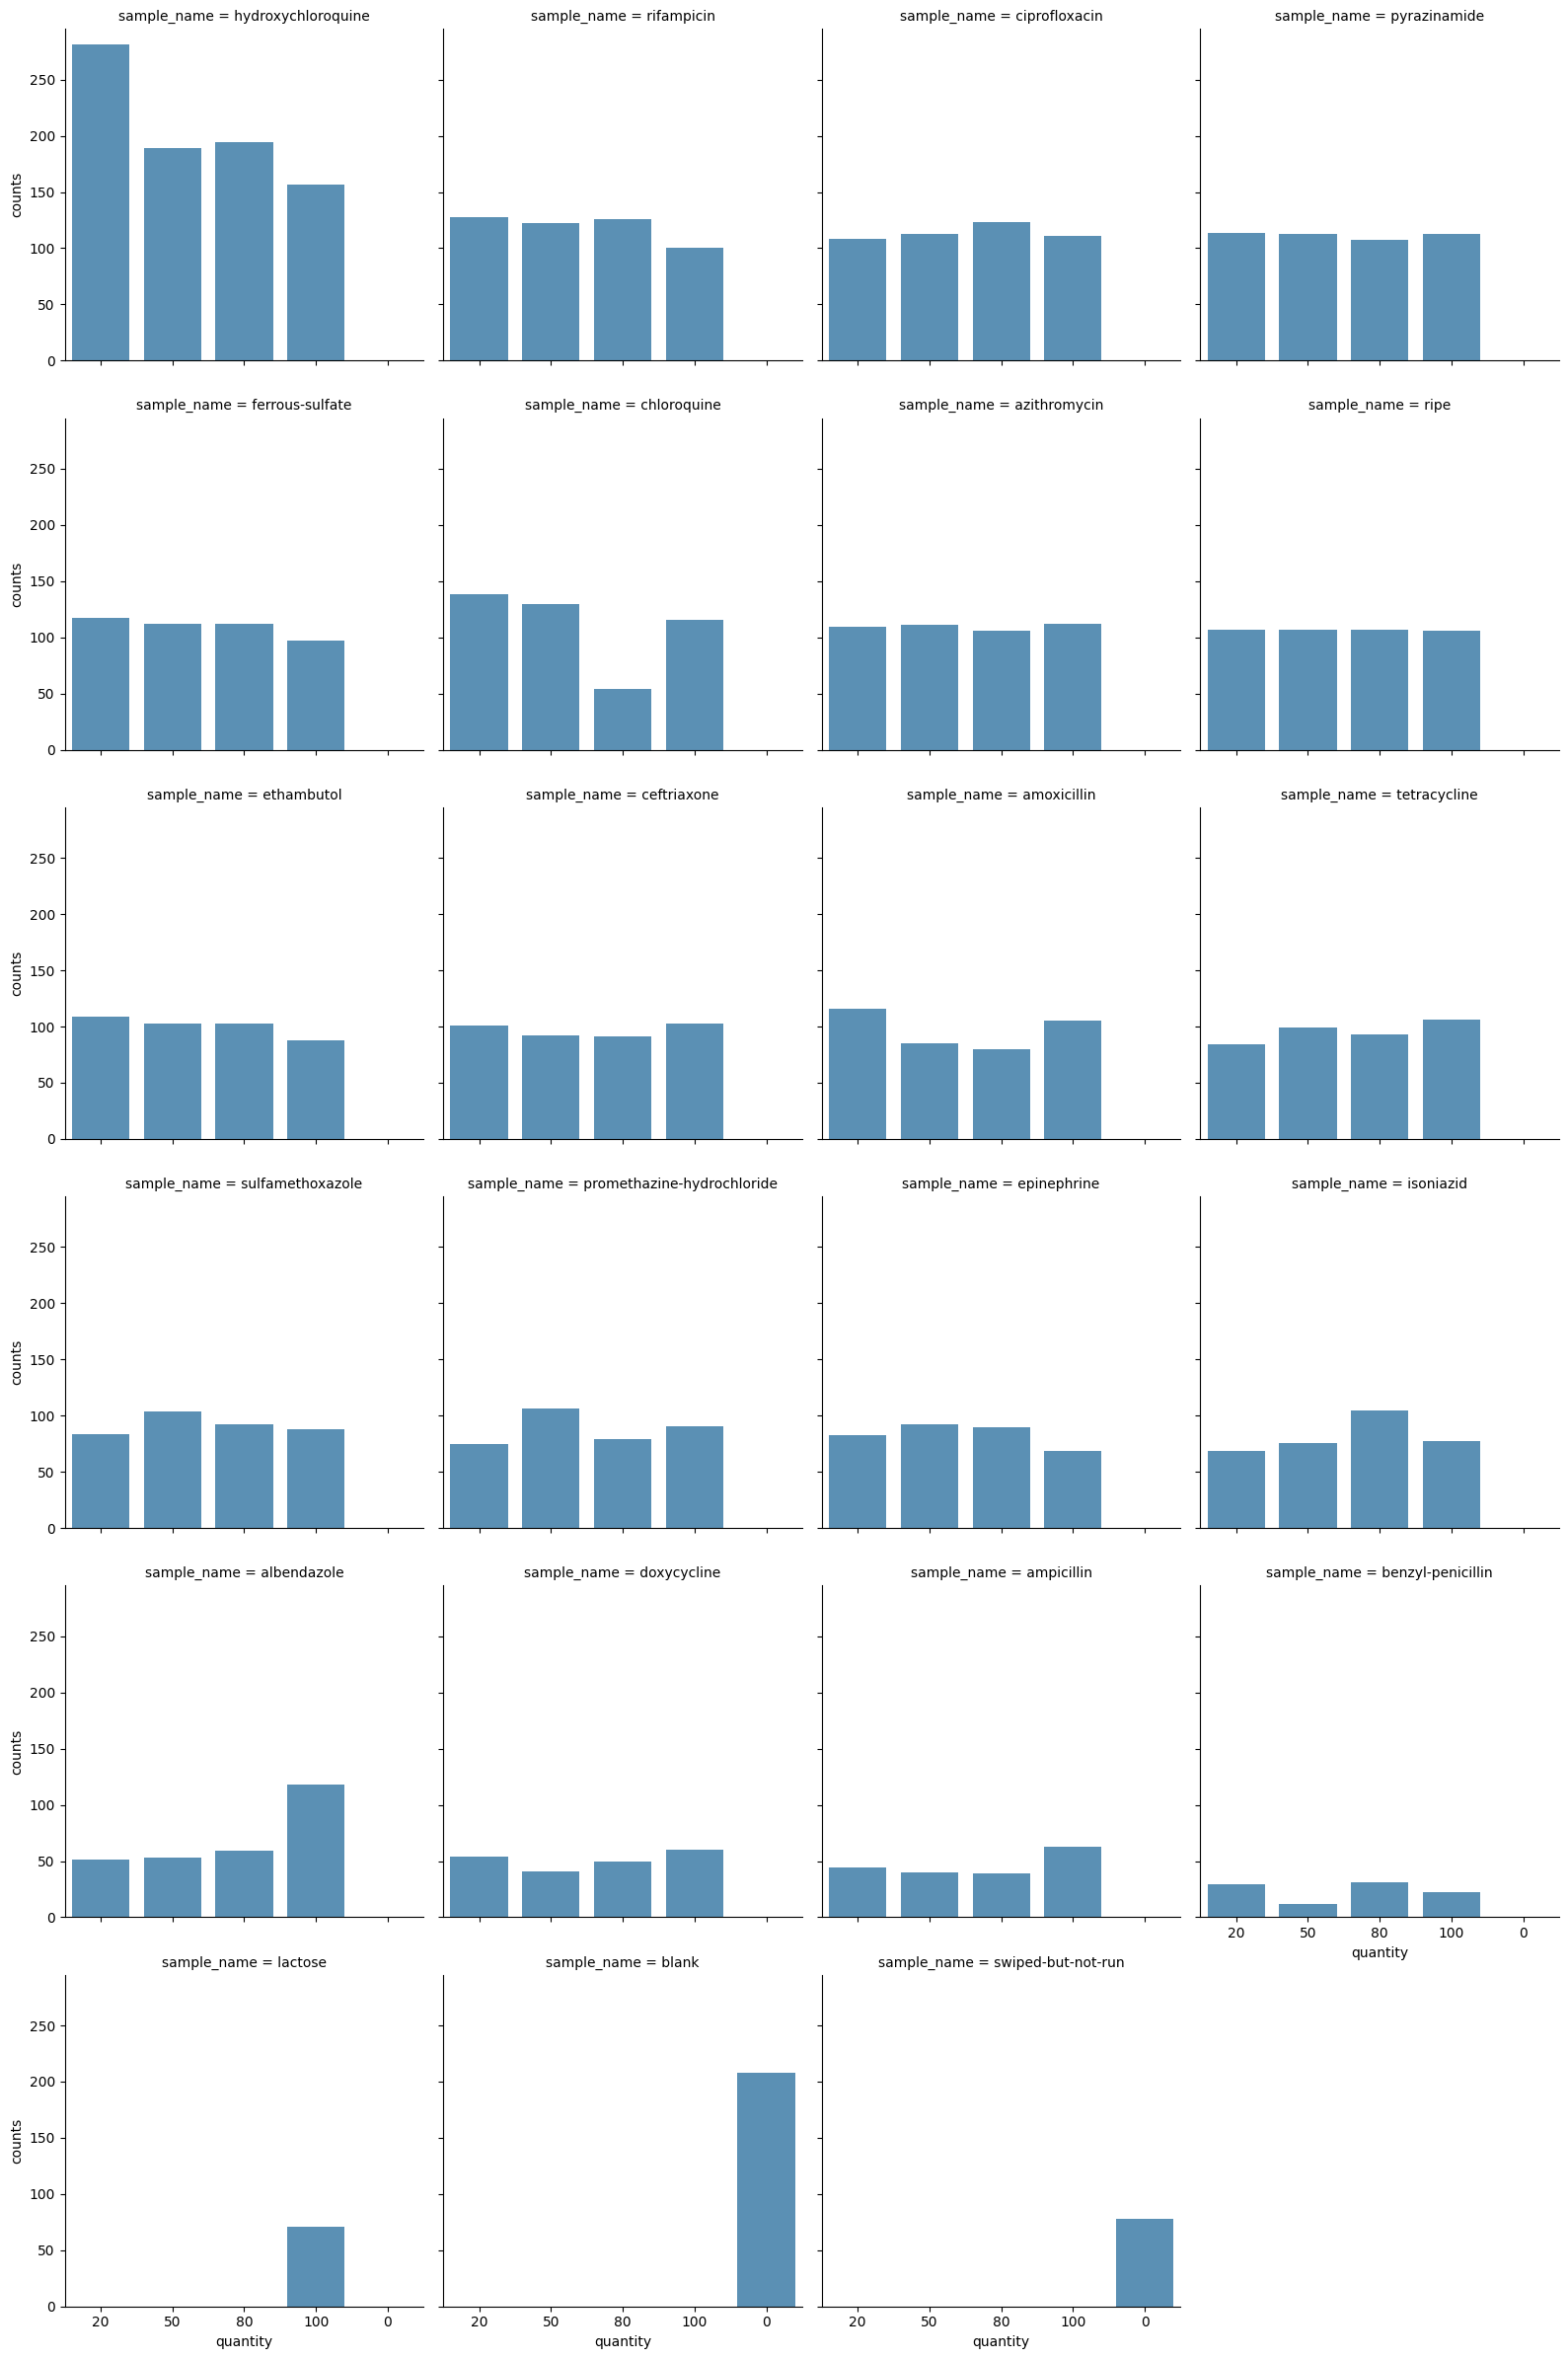

In [19]:
quantities = img_counter_by_drug_quantity.quantity.unique()
g = sns.FacetGrid(img_counter_by_drug_quantity, col="sample_name", col_wrap=4, height=4)
g.map(sns.barplot, 'quantity', "counts",  order=quantities, alpha=0.8)

#### Check images by camera type

In [20]:
data[['sample_id','sample_name','quantity', 'camera_type_1']].value_counts().reset_index(name='counts')

,sample_id,sample_name,quantity,camera_type_1,counts
0,53000,hydroxychloroquine,20,Galaxy S9,23
1,51730,hydroxychloroquine,20,Galaxy S9,19
2,53006,hydroxychloroquine,20,Galaxy S9,18
3,51727,hydroxychloroquine,20,Galaxy S9,17
4,53004,hydroxychloroquine,20,Galaxy S9,13
...,...,...,...,...,...
4100,55042,ripe,80,samsung SM-A505F,1
4101,55045,ripe,50,HMD Global Nokia 2.3,1
4102,55025,pyrazinamide,80,HMD Global Nokia 2.3,1
4103,53897,hydroxychloroquine,80,iPhone 11,1


#### Check the distribution of the number of images by camera 

In [21]:
img_counter_by_camera = data[['camera_type_1']].value_counts().reset_index(name='counts')
img_counter_by_camera

,camera_type_1,counts
0,samsung SM-A505F,3091
1,HMD Global Nokia 2.3,1792
2,Google Pixel 3a,1398
3,Galaxy S9,771
4,Heather Iphone XS,302
5,iPhone 11,201
6,BLU BLU R1 HD,142
7,Kat Galaxy S9,110
8,iPad,99
9,Jessica Galaxy,56


<Axes: xlabel='counts', ylabel='camera_type_1'>

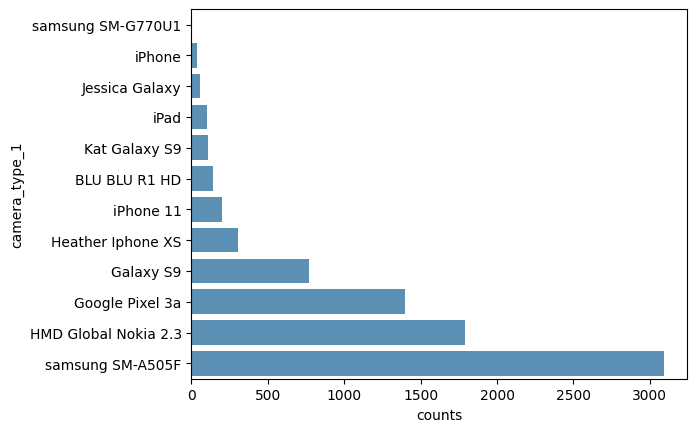

In [22]:
# Total of samples by drug
sns.barplot(img_counter_by_camera.sort_values(by=['counts']), x='counts', y="camera_type_1", orient="y", alpha=0.8)

#### Check the distribution of the number of images by camera and drug

<Axes: xlabel='sample_name', ylabel='camera_type_1'>

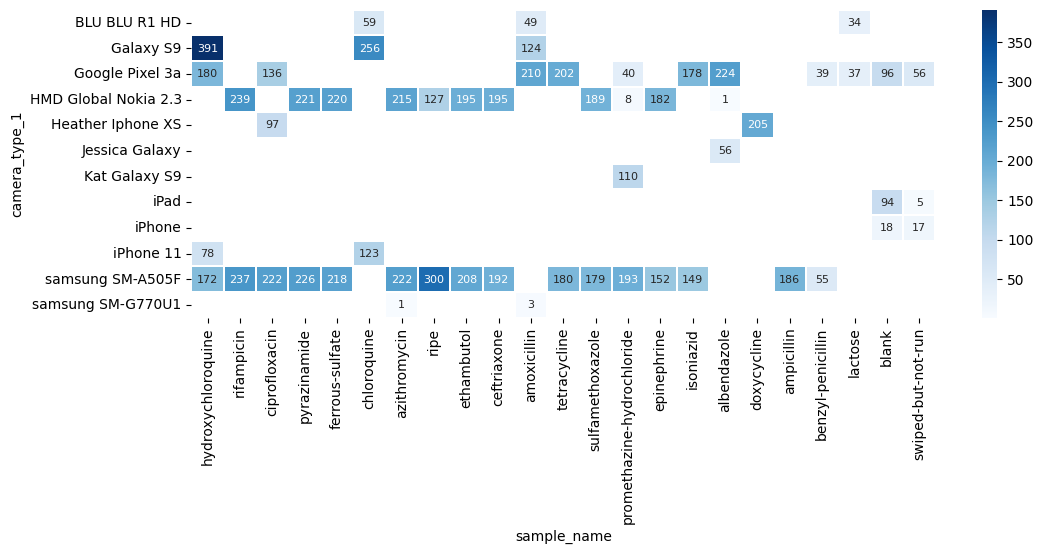

In [24]:
camera_quantity_counter = data[['camera_type_1', 'sample_name']].value_counts().reset_index(name='counts')
camera_quantity_counter_cat_rev = camera_quantity_counter.copy()
camera_quantity_counter_cat_rev['sample_name'] = pd.Categorical(camera_quantity_counter['sample_name'], name_list)

# plot heatmap
table = camera_quantity_counter_cat_rev.pivot(index="camera_type_1", columns="sample_name", values="counts")
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)


## 3.2. Analyze by Card

### Single samples

Here, I am disregarding whether the same PAD was photographed several times.

#### total of unique samples per `sample_name` (class/category)

In [25]:
samples_unique = data[['sample_id','sample_name']].value_counts().reset_index(name='counts')
print(f"Total of Unique samples {samples_unique.shape[0]}")

samples_unique_grp = samples_unique.groupby(['sample_name']).size().reset_index(name='counts')
unique_class_counter = samples_unique_grp.sort_values(by=['counts'], ascending=False).reset_index(drop=True)
print(f"{unique_class_counter['sample_name'].to_list()}")

Total of Unique samples 2245
['rifampicin', 'sulfamethoxazole', 'ciprofloxacin', 'doxycycline', 'chloroquine', 'ferrous-sulfate', 'azithromycin', 'isoniazid', 'amoxicillin', 'pyrazinamide', 'albendazole', 'ceftriaxone', 'hydroxychloroquine', 'ampicillin', 'ripe', 'tetracycline', 'ethambutol', 'promethazine-hydrochloride', 'epinephrine', 'blank', 'benzyl-penicillin', 'swiped-but-not-run', 'lactose']


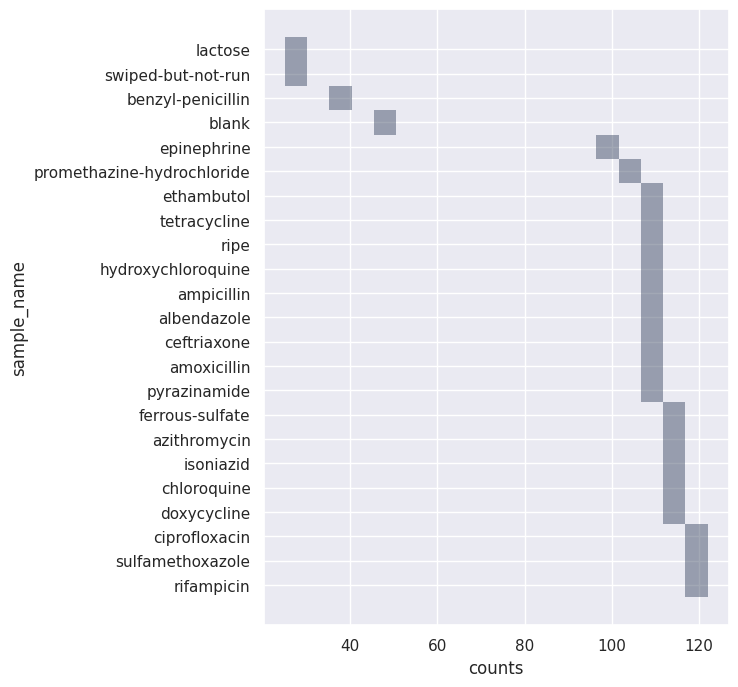

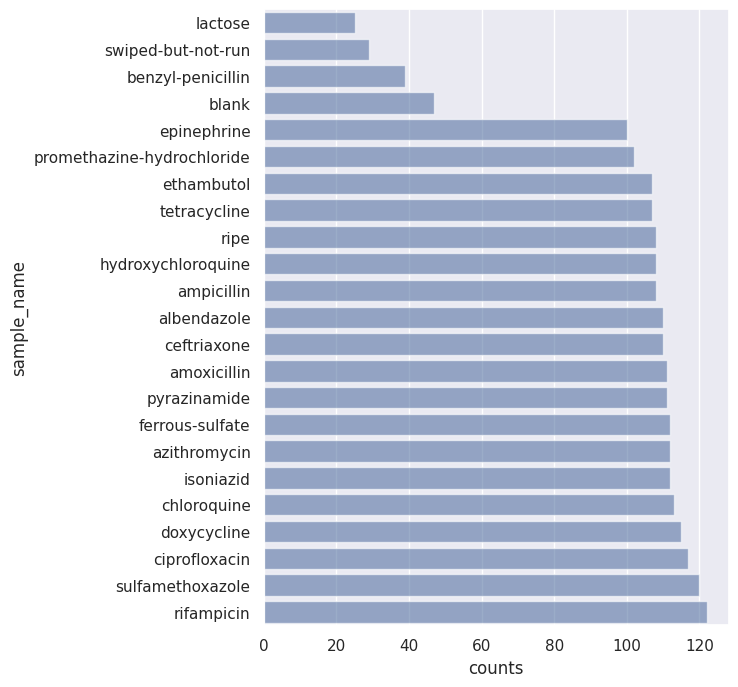

In [26]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(6, 8))
sns.histplot(data=samples_unique_grp.sort_values(by=['counts']), x="counts",  y="sample_name",  alpha=0.5, linewidths=.8)
plt.show()

fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(samples_unique_grp.sort_values(by=['counts']), x='counts', y="sample_name", orient="y", alpha=0.6)
plt.show()

In [27]:
samples_unique = data[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')

In [28]:
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df1

,sample_name,quantity,counts
0,blank,0,47
1,sulfamethoxazole,50,38
2,ampicillin,100,37
3,rifampicin,80,32
4,rifampicin,50,32
...,...,...,...
78,ampicillin,50,22
79,benzyl-penicillin,20,12
80,benzyl-penicillin,80,11
81,benzyl-penicillin,100,10


In [29]:
df2 = data[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2

,sample_name,quantity,counts
0,hydroxychloroquine,20,281
1,blank,0,208
2,hydroxychloroquine,80,194
3,hydroxychloroquine,50,189
4,hydroxychloroquine,100,157
...,...,...,...
78,ampicillin,80,39
79,benzyl-penicillin,80,31
80,benzyl-penicillin,20,29
81,benzyl-penicillin,100,22


In [30]:
df1.loc[df1.sample_name == 'hydroxychloroquine']

,sample_name,quantity,counts
41,hydroxychloroquine,20,27
46,hydroxychloroquine,100,27
47,hydroxychloroquine,80,27
48,hydroxychloroquine,50,27


In [31]:
df2.loc[df2.sample_name == 'hydroxychloroquine']

,sample_name,quantity,counts
0,hydroxychloroquine,20,281
2,hydroxychloroquine,80,194
3,hydroxychloroquine,50,189
4,hydroxychloroquine,100,157


NOTE: *`df1`* gives counts by **unique sample_id** and *`df2`* gives counts considering  **duplicated sample_id** (the total of picutures) 

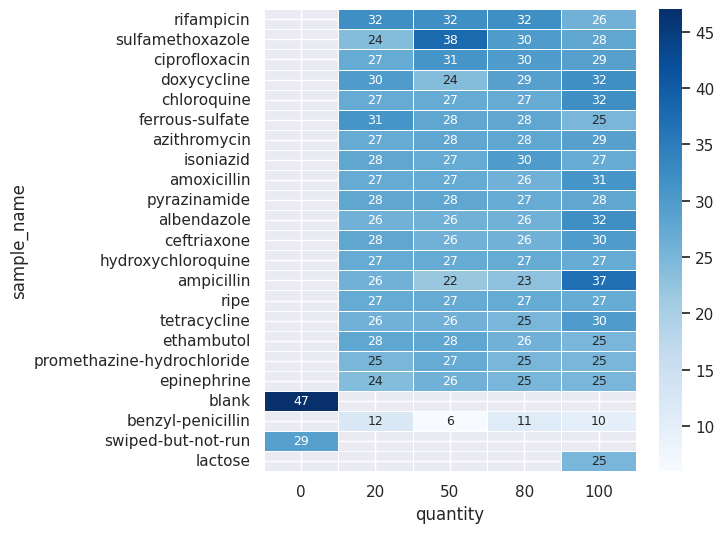

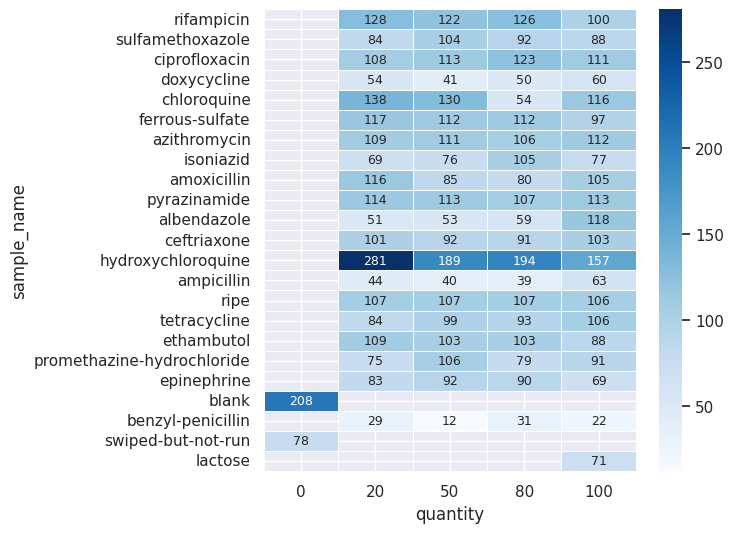

In [32]:
rows = "sample_name"
cols = "quantity"
values = "counts"
rows_order = unique_class_counter['sample_name'].to_list()

show_heatmap(df1, rows, cols, values, rows_order)
show_heatmap(df2, rows, cols, values, rows_order)

## 4. Split the dataset in development and test sets


Note: I removed the samples that are disctractors from the dataset.

In [33]:
def show_heatmap_tables(table1, table2, save_name=None, figsize=(18, 8),
                        caption="Your main caption here", title1="Table 1", title2="Table 2", cmap='Blues'):
    plt.rcParams["figure.autolayout"] = True
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.heatmap(table1, annot=True, annot_kws={"size": 9}, fmt='g', cmap=cmap, linewidths=.4, ax=axes[0])
    axes[0].set_title(title1)  # Title for the first heatmap

    sns.heatmap(table2, annot=True, annot_kws={"size": 9}, fmt='g', cmap=cmap, linewidths=.4, ax=axes[1])
    axes[1].set_title(title2)  # Title for the second heatmap

    plt.suptitle(caption)  # Main caption/title for the figure

    plt.show()
    
    if save_name: 
        fig.savefig(save_name, bbox_inches='tight')

In [34]:
data.reset_index(drop=True, inplace=True)

print(f"Total of images {len(data)}")

Total of images 8001


### See data before splitting

In [35]:

def show_heatmap(df, rows, cols, values, rows_order = None, save_name= None, figsize=(6, 6)):
    import pandas as pd 
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df_cat = df.copy()
    df_cat[rows] = pd.Categorical(df[rows], rows_order)
    table = df_cat.pivot(index=rows, columns=cols, values=values)
    
    fig, _ = plt.subplots(figsize=figsize)
    sns.heatmap(table, annot=True, annot_kws={"size": 9}, fmt='g', cmap='Blues', linewidths=.4)
    plt.show()
    if save_name: fig.savefig(save_name,bbox_inches='tight') 

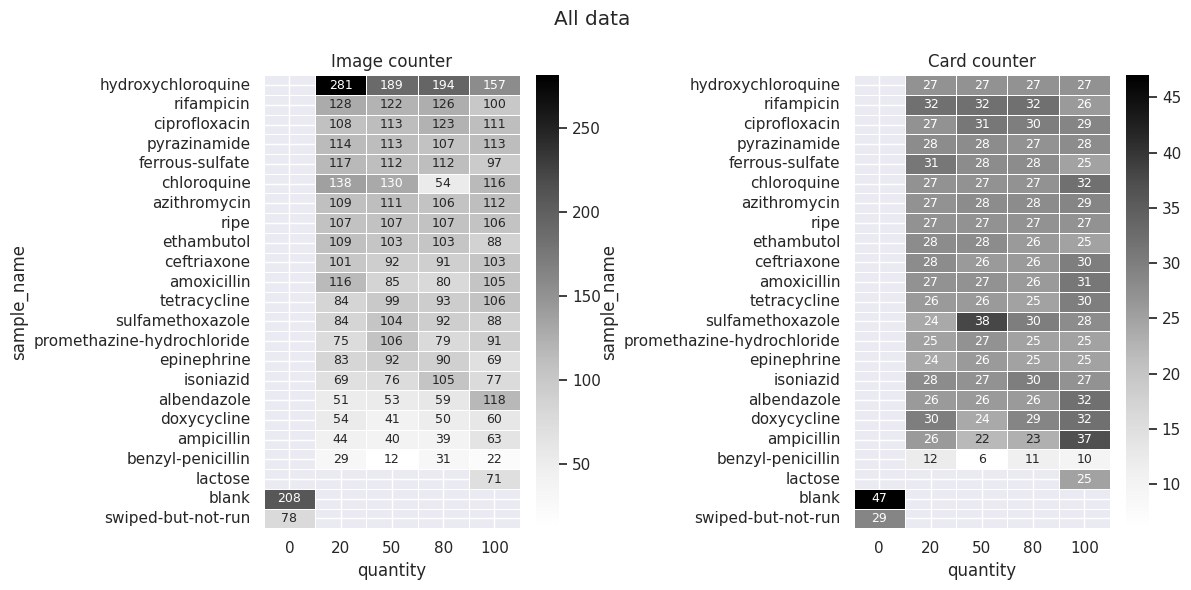

In [41]:
set_df = data
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
caption = f"All data"
title1="Image counter" 
title2="Card counter" 
cmap = "Greys"
rows_order = name_list

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)

show_heatmap_tables(table2, table1, save_name= f"{REPORT_DIR}/all_data.png", 
                    figsize=(12, 6), caption=caption, title1=title1, title2=title2, cmap=cmap) 

### Splitting Data

### See and Define splitting

In [57]:
drugs = data[data.is_drug].sample_name.unique()
quantities = data[data.is_drug].quantity.unique()
no_drugs = data[~data.is_drug].sample_name.unique()
no_drugs

array(['lactose', 'swiped-but-not-run', 'blank'], dtype=object)

- choose the split size

In [48]:
splits = [{'test_size': 0.10, 'cmap': "RdPu"},
          {'test_size': 0.15, 'cmap': "Purples"}, 
          {'test_size': 0.20, 'cmap': "Blues"}, 
          {'test_size': 0.25, 'cmap': "YlOrBr"},
          {'test_size': 0.30, 'cmap': "YlGn"},]

split_id=3

In [70]:
# Parameters of the splitting 
random_state = 42
test_size = splits[split_id]['test_size']
dev_size = 1 - test_size

# Parameters of the plots
cmap=splits[split_id]['cmap']
title1="Image counter" 
title2="Card counter" 
str_split = f" [Dev {int(dev_size*100)}% | Test {int(test_size*100)}%]" 

# Initialize the splitter
splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=random_state)

# I'll split based on 'sample_id' to ensure images of the same card stay together
# Assuming 'group' here would represent the combined 'sample_name' and 'quantity' for stratification
all_train_idx = []
all_test_idx = []
for sample_name in name_list:
    quantities = data[data.sample_name == sample_name].quantity.unique()
    for quantity in quantities:
        #print(f"\n{sample_name}\t{quantity}")
        subset = data[(data['sample_name'] == sample_name) & (data['quantity'] == quantity)]
        
        # Perform the split
        for train_idx, test_idx in splitter.split(subset, groups=subset['sample_id']):
            train_subset = subset.iloc[train_idx]
            test_subset = subset.iloc[test_idx]

            # append these subsets to the overall training and testing set indexes
            all_train_idx += train_subset.index.tolist()
            all_test_idx += test_subset.index.tolist()
            #print(f"train {len(train_idx)} test {len(test_idx)}")
            
test_df = data.iloc[all_test_idx].copy()
dev_df = data.iloc[all_train_idx].copy()

In [67]:
len(dev_df), len(test_df), (len(dev_df) + len(test_df))

(5923, 2078, 8001)

### See results

#### `test_df`

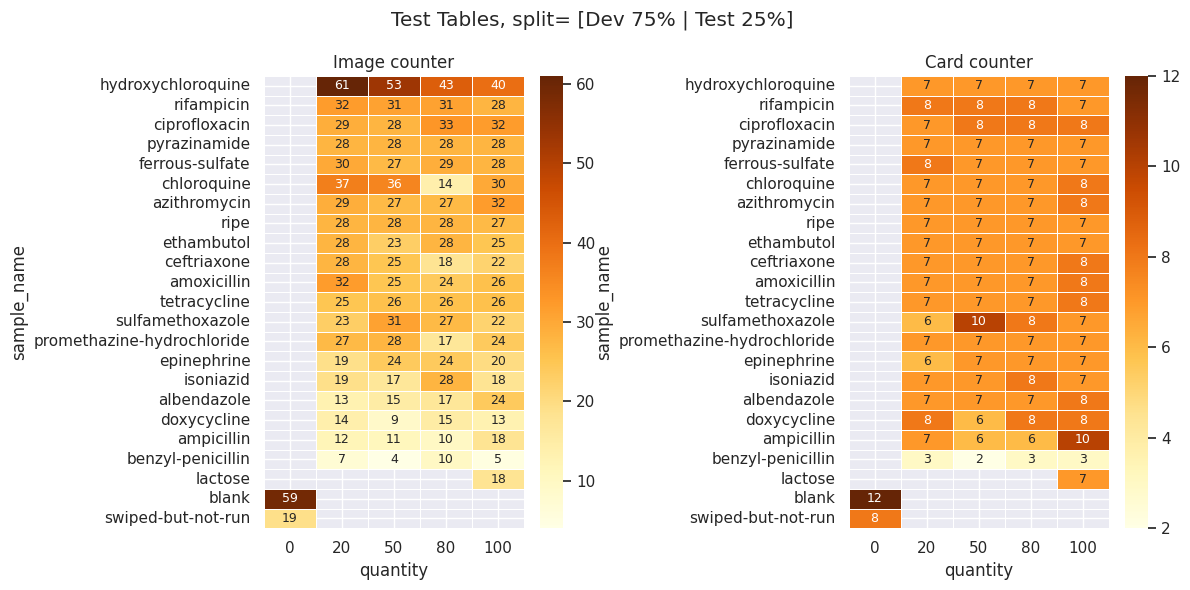

In [71]:
set_df = test_df
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
caption = f"Test Tables, split={str_split}"
rows_order = name_list

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)
show_heatmap_tables(table2, table1, save_name= f"{REPORT_DIR}/test__tsize_{str(int(test_size*100))}.png", 
                    figsize=(12, 6), caption=caption, title1=title1, title2=title2, cmap=cmap) 
                    

#### `train_val_df`

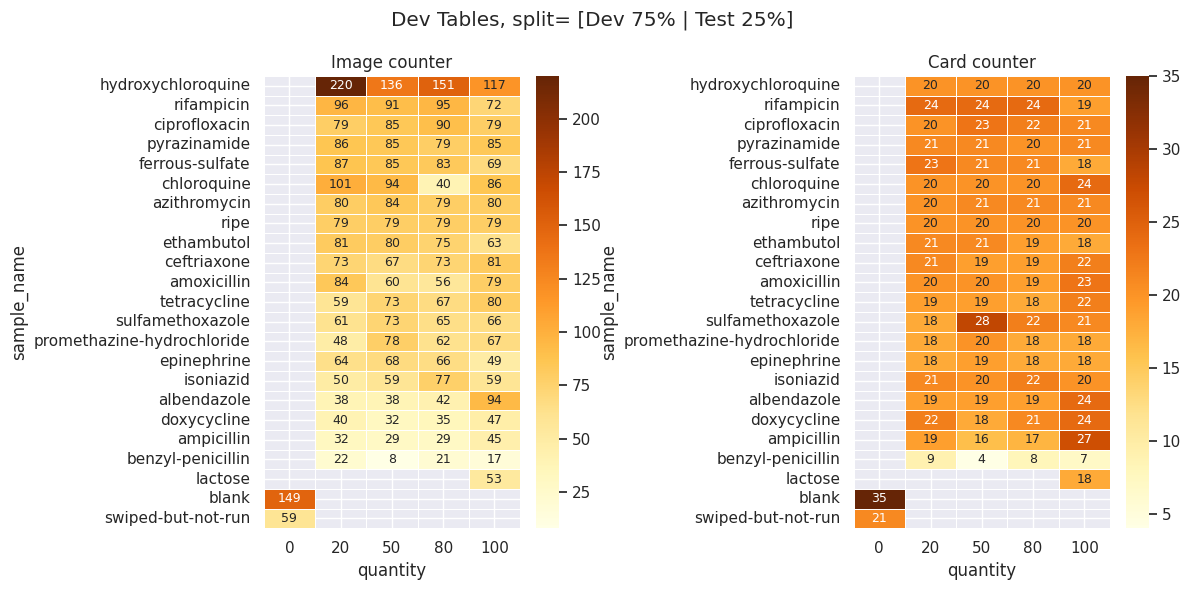

In [74]:
set_df = dev_df
samples_unique = set_df[['sample_id','sample_name','quantity']].value_counts().reset_index(name='counts')
df1 = samples_unique[['sample_name','quantity']].value_counts().reset_index(name='counts')
df2 = set_df[['sample_name','quantity']].value_counts().reset_index(name='counts')

rows = "sample_name"
cols = "quantity"
values = "counts"
caption = f"Dev Tables, split={str_split}"
rows_order = name_list

table1 = get_heatmap_table(df1, rows, cols, values, rows_order)
table2 = get_heatmap_table(df2, rows, cols, values, rows_order)
show_heatmap_tables(table2, table1, save_name= f"{REPORT_DIR}/dev__tsize_{str(int(test_size*100))}.png",
                    figsize=(12, 6), caption=caption, title1=title1, title2=title2, cmap=cmap) 

# show heatmap separately
#show_heatmap(df1, rows, cols, values, rows_order)


#### Camera type distribution

<Axes: xlabel='counts', ylabel='camera_type_1'>

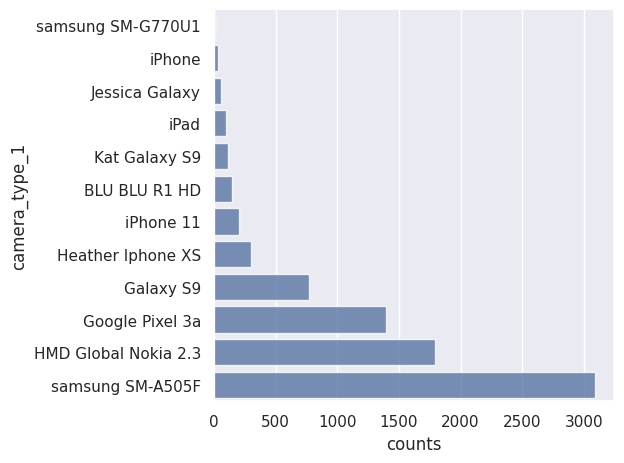

In [75]:
camera_counter = data[['camera_type_1']].value_counts().reset_index(name='counts')
camera_counter.sort_values(by=['counts'], inplace=True)
camera_counter

# Total of samples by camera type
sns.barplot(camera_counter, x='counts', y="camera_type_1", orient="y", alpha=0.8)

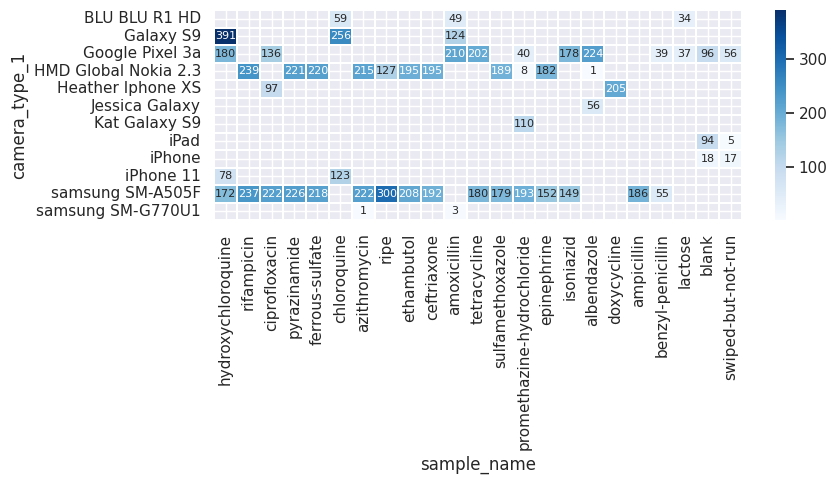

In [78]:
camera_quantity_counter = data[['camera_type_1', 'sample_name']].value_counts().reset_index(name='counts')
camera_quantity_counter_cat_rev = camera_quantity_counter.copy()
camera_quantity_counter_cat_rev['sample_name'] = pd.Categorical(camera_quantity_counter['sample_name'], name_list) #, sample_name_list[::-1])

# plot heatmap
table = camera_quantity_counter_cat_rev.pivot(index="camera_type_1", columns="sample_name", values="counts")
fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(table, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', linewidths=.3)

fig.savefig(f"{REPORT_DIR}/camera_drug_heatmap.png", bbox_inches='tight') 

### General Stats

In [82]:
# Size of sets considering all images
print(f"# Size of sets considering all images")
print(f" - train_val: {len(dev_df)}")
print(f" - test: {len(test_df)}")
print(f" - total: {len(data)}")
print()

# Size of sets considering unique sample_ids
print(f"# Size of sets considering unique sample_ids")
print(f" - train_val: {len(dev_df.groupby(['sample_id']))}")
print(f" - test: {len(test_df.groupby(['sample_id']))}")
print(f" - total: {len(data.groupby(['sample_id']))}")
print()

# Size of sets considering all images
 - train_val: 5923
 - test: 2078
 - total: 8001

# Size of sets considering unique sample_ids
 - train_val: 1644
 - test: 587
 - total: 2226



#### Check if the sets don't have intersections in terms of sample_id

In [81]:
ids_test = test_df.loc[(test_df.sample_name == 'benzyl-penicillin') & (test_df.quantity == 20), 'sample_id']
ids_dev = dev_df.loc[(dev_df.sample_name == 'benzyl-penicillin') & (dev_df.quantity == 20), 'sample_id']

pd.Series(list(set(ids_dev).intersection(set(ids_test))))

Series([], dtype: object)

# 5. Save dataframes for test and dev sets in csv files

In [87]:
# create a column for image file names in both dataframes 
test_df['image_name'] = test_df.apply(lambda x: create_filename(x), axis=1)
dev_df['image_name'] = dev_df.apply(lambda x: create_filename(x), axis=1)

# columns to be saved
column_name_list = ['id','sample_id', 'sample_name', 'quantity', 'camera_type_1', 'url', 'hashlib_md5', 'image_name'] 

# save to csv
test_df[column_name_list].to_csv(f"{DATASET_ROOT_DIR}/metadata_test.csv", index=False)
dev_df[column_name_list].to_csv(f"{DATASET_ROOT_DIR}/metadata_dev.csv", index=False)

## 6. Save metadata


### Set Dataset General Metadata

In [147]:
# dataset_name = 'FHI2020_Stratified_Sampling'
# dataset_description = """This dataset is based on data from Project FHI2020 and comprises images from PADs, each representing a specific API from a predefined list of 20 APIs and one of four possible quantities (20, 50, 80, 100). The dataset features multiple images of the same PAD, captured under varying illumination conditions and using different devices, each image uniquely identified by an image_id, while cards share a sample_id. To address the challenge posed by its unbalanced nature regarding API names and quantities, a stratified sampling approach was employed for data splitting. Specifically, the dataset was divided such that for each API, and within each quantity category of that API, 10% of the PADs(considering all their photographs) were allocated to the test set, ensuring a proportional representation across both developing and testing subsets. This method not only maintains the balance of API types and quantities but also ensures that all photographs of the same PAD are kept together, either in the developing or the test set, to prevent data leakage and promote model generalizability.There are no distractors included in this dataset."""
# dev_size = 1 - test_size
# random_state = 42
# hash_type = 'hashlib_md5'


### Save metadata to the yaml file

In [148]:
# import pandas as pd
# import yaml

# # Iterate through each row in the dataframe and add pad information to metadata
# def add_pad_info_to_metadata(dataframe, metadata, dataset_name):
#     for index, row in dataframe.iterrows():
#         pad_info = {
#             'id': row['id'],
#             'sample_id': row['sample_id'],
#             'sample_name': row['sample_name'],
#             'quantity': row['quantity'],            
#             'filename': create_filename(row),
#             'image_hash': row[hash_type],
#             'image_source': row['url']
#         }
#         metadata[dataset_name].append(pad_info)

# metadata = {
#     'name': dataset_name,
#     'description': dataset_description,
#     'creation':  get_iso8601_datetime(),
#     'split': {  # Save information about the dataset splitting in development and test sets
#         'dev_size': dev_size,        
#         'random_seed': random_state
#     },
#     'hash_type': hash_type,
#     'dev_set': [], # train_val_df
#     'test_set': [] # test_df
# }

# # Create a path for that dataset
# dataset_path = os.path.join( "../datasets/", dataset_name) 
# os.makedirs(dataset_path, exist_ok=True)

# # add metadata for each subset
# add_pad_info_to_metadata(train_val_df, metadata, 'dev_set')
# add_pad_info_to_metadata(test_df, metadata, 'test_set')

# # Convert the metadata dictionary to YAML format
# yaml_output = yaml.dump(metadata, sort_keys=False)

# # Save the YAML data to a file
# fpath = os.path.join(dataset_path, "metadata.yaml")
# with open(fpath, 'w') as yaml_file:
#     yaml_file.write(yaml_output)

# print("Metadata file 'metadata.yaml' has been created.")


Metadata file 'metadata.yaml' has been created.


## 7. Save images 

In [135]:
import shutil
import os

def copy_images(image_names, source_folder, destination_folder):
    """
    Copies specified images from a source folder to a destination folder.

    Parameters:
    - image_names: List of image file names to copy.
    - source_folder: Path to the source folder where the images are located.
    - destination_folder: Path to the destination folder where images will be copied.
    """
    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Copy each specified image from the source to the destination folder
    for image_name in image_names:
        source_path = os.path.join(source_folder, image_name)
        destination_path = os.path.join(destination_folder, image_name)
        
        # Check if the file exists to avoid errors
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            #print(f"Copied {image_name} to {destination_folder}")
        else:
            print(f"Image {image_name} does not exist in the source folder.")

# # Example usage
# image_names = ['example1.jpg', 'example2.png']
# source_folder = '/path/to/source/folder'
# destination_folder = '/path/to/destination/folder'

# # Call the function with your specific parameters
# copy_images(image_names, source_folder, destination_folder)


In [138]:
# move images to the dataset folder

source = '../datasets/FHI2020_Stratified_Sampling/images'
destination_dev = '../datasets/FHI2020_Stratified_Sampling/dev_images'
destination_test = '../datasets/FHI2020_Stratified_Sampling/test_images'

# copy 'dev images' from source to destination_dev
copy_images(dev_df.image_name.to_list(), source, destination_dev)

# copy 'test images' from source to destination_test
copy_images(test_df.image_name.to_list(), source, destination_test)

## 6. Persist the data and info with DVC


```bash
# images
!dvc add datasets/FHI2020_Stratified_Sampling/dev_images/
!dvc add datasets/FHI2020_Stratified_Sampling/test_images/
# metadata
!dvc add datasets/FHI2020_Stratified_Sampling/metadata_dev.csv
!dvc add datasets/FHI2020_Stratified_Sampling/metadata_test.csv
# report
!dvc add datasets/FHI2020_Stratified_Sampling/report

!dvc commit
!dvc push

```